**Train YOLO model**

Original Author: Bubbliiiing

Edit / Rewrite / Comment By: Hammond Liu (hl3797)

Github Link: [yolov4-pytorch](https://github.com/bubbliiiing/yolov4-pytorch)


In [ ]:
# # Mount to Google Drive to train on Colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# The working path of this code file should be inside the yolo folder
from os import chdir, listdir

print(listdir('./'))

# chdir('/content/drive/MyDrive/Sem_3/ML/F20_ML_final_project/yolo/')
# print(listdir('./'))

['.ipynb_checkpoints', 'annotation_preprocess.ipynb', 'data', 'eval.ipynb', 'loss_data', 'map', 'nets', 'predict.ipynb', 'test_img', 'train.ipynb', 'utils', 'yolo.py', '__pycache__']


In [5]:
import os
import time
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from nets.yolo4 import YoloBody
from nets.yolo_training import YOLOLoss, Generator

In [6]:
# Read the format data info from input files

# = = = = = = = = = = Code Citation Start = = = = = = = = = = #
#                                                             #
#  The code here are implemented by the cited Github project. #
#  Gitgub Project Path: /yolov4-pytorch/blob/master/train.py  #
#                                                             #
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape([-1,3,2])[::-1,:,:]
#                                                             #
# = = = = = = = = = = Code Citation End = = = = = = = = = = = #

anchors_path = './data/anchors.txt'
classes_path = './data/classes.txt'   
class_names = get_classes(classes_path)
anchors = get_anchors(anchors_path)
num_classes = len(class_names)

In [7]:
# Train one epoch

# = = = = = = = = = = = = Code Citation Start = = = = = = = = = = = = #
#                                                                     #
#     Key steps of this function are implemented in cited project.    #
#     We rewrite a few parts to fit the need of our project.          #
#     Gitgub Project Path: /yolov4-pytorch/blob/master/train.py       #
#                                                                     #
def fit_one_epoch(net, yolo_losses, epoch, epoch_size, epoch_size_val, gen,genval, Epoch, cuda, optimizer, lr_scheduler):
    total_loss = 0
    val_loss = 0
    print('\n' + '-' * 10 + 'Train one epoch.' + '-' * 10)
    print('Epoch:'+ str(epoch+1) + '/' + str(Epoch))
    print('Start Training.')
    net.train()
    for iteration in range(epoch_size):
        start_time = time.time()
        images, targets = next(gen)
        with torch.no_grad():
            if cuda:
                images = Variable(torch.from_numpy(images).type(torch.FloatTensor)).cuda()
                targets = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets]
            else:
                images = Variable(torch.from_numpy(images).type(torch.FloatTensor))
                targets = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets]
        optimizer.zero_grad()
        outputs = net(images)
        losses = []
        for i in range(3):
            loss_item = yolo_losses[i](outputs[i], targets)
            losses.append(loss_item[0])
        loss = sum(losses)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss
        waste_time = time.time() - start_time
        if iteration == 0 or (iteration+1) % 10 == 0:
            print(('step: %02d' % (iteration+1)) + '/' + str(epoch_size) + ' || Total Loss: %.4f || %.4fs/step' % (total_loss/(iteration+1), waste_time))
    print('Finish Training.')
            
    print('Start Validation.')
    net.eval()
    for iteration in range(epoch_size_val):
        images_val, targets_val = next(genval)

        with torch.no_grad():
            if cuda:
                images_val = Variable(torch.from_numpy(images_val).type(torch.FloatTensor)).cuda()
                targets_val = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets_val]
            else:
                images_val = Variable(torch.from_numpy(images_val).type(torch.FloatTensor))
                targets_val = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets_val]
            optimizer.zero_grad()
            outputs = net(images_val)
            losses = []
            for i in range(3):
                loss_item = yolo_losses[i](outputs[i], targets_val)
                losses.append(loss_item[0])
            loss = sum(losses)
            val_loss += loss
    print('Finish Validation')
    
    print('Total Loss: %.4f || Val Loss: %.4f ' % (total_loss/(epoch_size+1), val_loss/(epoch_size_val+1)))
    
    return total_loss/(epoch_size+1), val_loss/(epoch_size_val+1)

#                                                                     #
# = = = = = = = = = = = = Code Citation End = = = = = = = = = = = = = #

In [8]:
# Initialize variables

# = = = = = = = = = = = = Code Citation Start = = = = = = = = = = = = #
#                                                                     #
#     Here, we followed the parameter settings in the cited project.  #
#     Gitgub Project Path: /yolov4-pytorch/blob/master/train.py       #
#                                                                     #

input_shape = (416,416)

# Apply [cosine lr decay] and [mosaic data augment]
Cosine_lr = True
mosaic = True

Cuda = True
smoooth_label = 0.03

#                                                                     #
# = = = = = = = = = = = = Code Citation End = = = = = = = = = = = = = #

train_annotation_path = './data/train_data.txt'
val_annotation_path = './data/val_data.txt'

In [9]:
# = = = = = = = = = = = = Code Citation Start = = = = = = = = = = = = #
#                                                                     #
#     The code here are implemented by the cited Github project.      #
#     Gitgub Project Path: /yolov4-pytorch/blob/master/train.py       #
#                                                                     #

# Create the model & Load pretrained weights
model = YoloBody(len(anchors[0]), num_classes)


model_path = "./data/yolov4_test.pth"
# model_path = "./data/yolov4_coco_pretrained_weights.pth"
print('Loading pretrained model weights.')
model_dict = model.state_dict()
pretrained_dict = torch.load(model_path)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) ==  np.shape(v)}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
print('Finished!')

# Use cuda for training
if Cuda:
    net = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    net = net.cuda()

# Set up YOLO loss function
yolo_losses = []
for i in range(3):
    yolo_losses.append(YOLOLoss(np.reshape(anchors, [-1,2]), num_classes, \
                                (input_shape[1], input_shape[0]), smoooth_label, Cuda))
    
#                                                                     #
# = = = = = = = = = = = = Code Citation End = = = = = = = = = = = = = #

# Read train & val data
with open(train_annotation_path) as f:
    train_lines = f.readlines()
with open(val_annotation_path) as f:
    val_lines = f.readlines()
num_train = len(train_lines)
num_val = len(val_lines)

Loading pretrained model weights.
Finished!


In [10]:
# = = = = = = = = = = = = Code Citation Start = = = = = = = = = = = = #
#                                                                     #
#   Key steps of this function are implemented in cited project,      #
#   then we rewrite quite a lot to fit the need of our project.       #
#   Gitgub Project Path: /yolov4-pytorch/blob/master/train.py         #
#                                                                     #

def train(param_str, lr1 = 1e-3, lr2 = 1e-4, Batch_size1 = 4, Batch_size2 = 2, Init_Epoch = 0, Freeze_Epoch = 20, Unfreeze_Epoch = 40, dump_half = False):
    
    # Use Adam optimization & Apply cosine annealing lr
    optimizer = optim.Adam(net.parameters(), lr1, weight_decay = 5e-4)
    # optimizer = optim.SGD(net.parameters(), lr1, weight_decay = 5e-4)
    if Cosine_lr:
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)
    else:
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Apply mosaic data augment
    gen = Generator(Batch_size1, train_lines, (input_shape[0], input_shape[1])).generate(mosaic = mosaic)
    gen_val = Generator(Batch_size1, val_lines, (input_shape[0], input_shape[1])).generate(mosaic = False)

    # Compute epoch size & Set requires_grad
    epoch_size = int(max(1, num_train // Batch_size1 // 2.5)) if mosaic else max(1, num_train // Batch_size1)
    epoch_size_val = num_val // Batch_size1
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Training
    best_loss = 10e8
    val_loss_list = []
    train_loss_list = []
    best_model_weights = copy.deepcopy(net.state_dict())

    for epoch in range(Init_Epoch, Freeze_Epoch):
        # Fit one epoch
        total_loss, val_loss = fit_one_epoch(net, yolo_losses, epoch, epoch_size, epoch_size_val, gen, gen_val, 
                                            Freeze_Epoch, Cuda, optimizer, lr_scheduler)
        # Update the best loss if needed
        if total_loss < best_loss:
            best_loss = total_loss
            best_model_weights = copy.deepcopy(model.state_dict())
        
        # Record the loss data
        train_loss_list.append(str(total_loss.item()))
        val_loss_list.append(str(val_loss.item()))

    if dump_half:
        torch.save(best_model_weights, './data/yolo_fmd_' + param_str + '_half.pth')

    # Use Adam optimization & Apply cosine annealing lr
    optimizer = optim.Adam(net.parameters(), lr2, weight_decay=5e-4)
    # optimizer = optim.SGD(net.parameters(), lr2, weight_decay = 5e-4)
    if Cosine_lr:
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)
    else:
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Apply mosaic data augment
    gen = Generator(Batch_size2, train_lines, (input_shape[0], input_shape[1])).generate(mosaic = mosaic)
    gen_val = Generator(Batch_size2, val_lines, (input_shape[0], input_shape[1])).generate(mosaic = False)

    # Compute epoch size & Set requires_grad    
    epoch_size = int(max(1, num_train // Batch_size2 // 2.5)) if mosaic else max(1, num_train // Batch_size2)
    epoch_size_val = num_val // Batch_size2
    for param in model.backbone.parameters():
        param.requires_grad = True

    # Training the second half
    for epoch in range(Freeze_Epoch, Unfreeze_Epoch):
        # Fit one epoch
        total_loss, val_loss = fit_one_epoch(net, yolo_losses, epoch, epoch_size, epoch_size_val, gen, gen_val, 
                                            Unfreeze_Epoch, Cuda, optimizer, lr_scheduler)
        # Update the best loss (if needed)
        if total_loss < best_loss:
            best_loss = total_loss
            best_model_weights = copy.deepcopy(model.state_dict())

        # Record the loss data
        train_loss_list.append(str(total_loss.item()))
        val_loss_list.append(str(val_loss.item()))

    with open('./loss_data/total_loss_' + param_str + '.csv', mode='w') as total_loss_file:
        total_loss_file.write('\n'.join(train_loss_list))
    with open('./loss_data/val_loss_' + param_str + '.csv', mode='w') as val_loss_file:
        val_loss_file.write('\n'.join(val_loss_list))

    # Save the final weights
    torch.save(best_model_weights, './data/yolo_fmd_' + param_str + '.pth')

#                                                                     #
# = = = = = = = = = = = = Code Citation End = = = = = = = = = = = = = #

In [ ]:
# Call the train function can start training by default params

# train('adam_cs_40', Freeze_Epoch = 1, Unfreeze_Epoch = 2)

train('adam_cs_40')


----------Train one epoch.----------
Epoch:1/20
Start Training.
step: 01/46 || Total Loss: 7164.4771 || 0.9976s/step
step: 10/46 || Total Loss: 5579.2422 || 0.8422s/step
step: 20/46 || Total Loss: 4423.8154 || 0.8212s/step
step: 30/46 || Total Loss: 3570.2112 || 0.8892s/step
step: 40/46 || Total Loss: 2952.5696 || 0.7249s/step
Finish Validation
Total Loss: 2606.6470 || Val Loss: 624.8618 

----------Train one epoch.----------
Epoch:2/20
Start Training.
step: 01/46 || Total Loss: 691.2797 || 0.7325s/step
step: 10/46 || Total Loss: 581.6378 || 0.7793s/step
step: 20/46 || Total Loss: 512.1458 || 0.8224s/step
step: 30/46 || Total Loss: 458.1548 || 0.7062s/step
step: 40/46 || Total Loss: 419.3497 || 0.8001s/step
Finish Training.
Start Validation.
Finish Validation
Total Loss: 391.1996 || Val Loss: 204.6994 

----------Train one epoch.----------
Epoch:3/20
Start Training.
step: 01/46 || Total Loss: 247.4144 || 0.7941s/step
step: 10/46 || Total Loss: 237.4901 || 0.7535s/step
step: 20/46 || T

Text(0.5, 1.0, 'YOLO V4 - 40 epochs - SGD optim')

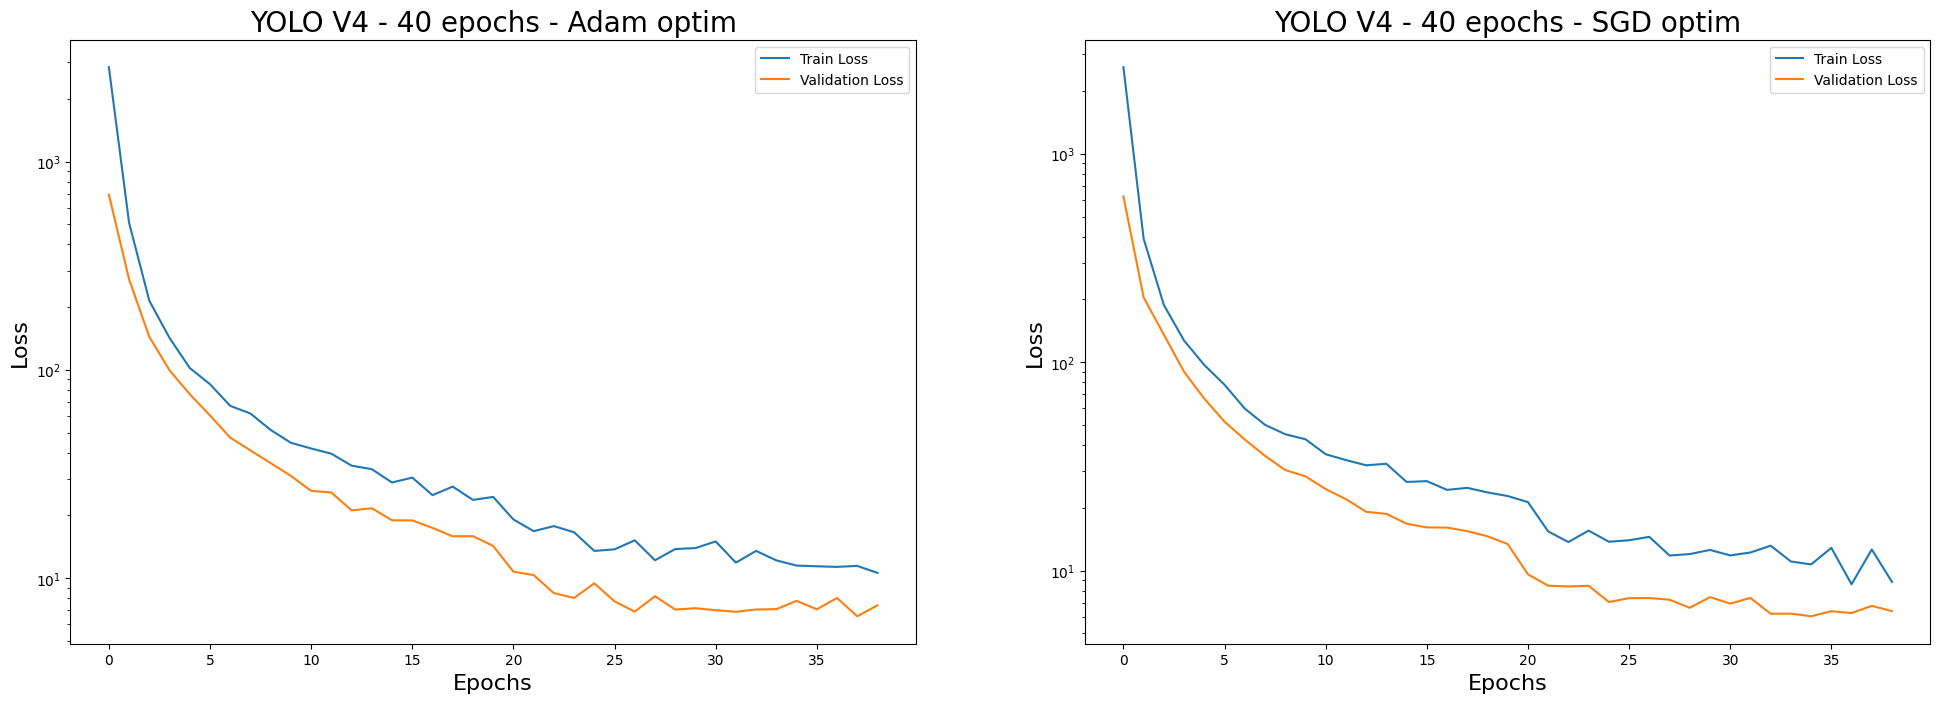

In [ ]:
# Plot the losses

total_loss_path = './loss_data/total_loss_adam_cs_40.csv'
val_loss_path = './loss_data/val_loss_adam_cs_40.csv'

with open(total_loss_path, 'r') as f:
    tl = [float(i) for i in f.read().split('\n')[:-1]]
with open(val_loss_path, 'r') as f:
    vl = [float(i) for i in f.read().split('\n')[:-1]]

fig = plt.figure(figsize = (24, 8), dpi = 100)
fig.add_subplot(1, 2, 1)
plt.semilogy(tl, label = 'Train Loss')
plt.semilogy(vl, label = 'Validation Loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.title('YOLO V4 - 40 epochs - Adam optim', fontsize=20)

total_loss_path = './loss_data/total_loss_sgd_cs_40.csv'
val_loss_path = './loss_data/val_loss_sgd_cs_40.csv'

with open(total_loss_path, 'r') as f:
    tl = [float(i) for i in f.read().split('\n')[:-1]]
with open(val_loss_path, 'r') as f:
    vl = [float(i) for i in f.read().split('\n')[:-1]]

fig.add_subplot(1, 2, 2)
plt.semilogy(tl, label = 'Train Loss')
plt.semilogy(vl, label = 'Validation Loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.title('YOLO V4 - 40 epochs - SGD optim', fontsize=20)

# fig = plt.figure(figsize = (10, 10), dpi = 80)
# fig.add_subplot(2, 1, 1)
# plt.semilogy(tl)
# plt.xlabel('Epochs')
# plt.ylabel('Train Loss')
# fig.add_subplot(2, 1, 2)
# plt.semilogy(vl)
# plt.xlabel('Epochs')
# plt.ylabel('Val Loss')